# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from datetime import datetime
import joblib
import warnings
warnings.filterwarnings("ignore")

In [2]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


# Loading the Data

In [3]:
data = pd.read_csv(r'C:\\Users\\Deeksha Mahesh\\Downloads\\historical_data.xls')

# Initial Exploration

In [4]:
print("Data Head:\n", data.head())
print("\nData Info:\n", data.info())
print("\nMissing Values:\n", data.isnull().sum())


Data Head:
    market_id           created_at actual_delivery_time  store_id  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:27:16      1845   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:56:29      5477   
2        3.0  2015-01-22 20:39:28  2015-01-22 21:09:09      5477   
3        3.0  2015-02-03 21:21:45  2015-02-03 22:13:00      5477   
4        3.0  2015-02-15 02:40:36  2015-02-15 03:20:26      5477   

  store_primary_category  order_protocol  total_items  subtotal  \
0               american             1.0            4      3441   
1                mexican             2.0            1      1900   
2                    NaN             1.0            1      1900   
3                    NaN             1.0            6      6900   
4                    NaN             1.0            3      3900   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1               

# Feature Engineering

# Calculate target: delivery duration

In [5]:
data['created_at'] = pd.to_datetime(data['created_at'])
data['actual_delivery_time'] = pd.to_datetime(data['actual_delivery_time'])
data['delivery_duration'] = (data['actual_delivery_time'] - data['created_at']).dt.total_seconds()

# Extracting date-time features

In [6]:
data['created_hour'] = data['created_at'].dt.hour
data['created_dayofweek'] = data['created_at'].dt.dayofweek

# Drop unused columns

In [7]:
data.drop(['created_at', 'actual_delivery_time'], axis=1, inplace=True)

# Handling Categorical Variables

In [8]:
categorical_cols = ['store_primary_category', 'market_id']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le

# Filling missing values

In [9]:
data.fillna(data.median(), inplace=True)

# Data Visualization: Distribution of Target Variable

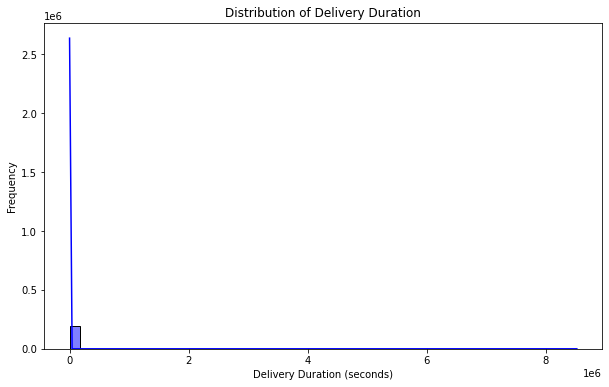

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(data['delivery_duration'], bins=50, kde=True, color='blue')
plt.title('Distribution of Delivery Duration')
plt.xlabel('Delivery Duration (seconds)')
plt.ylabel('Frequency')
plt.show()


# Box Plot: Delivery Duration vs Hour of the Day

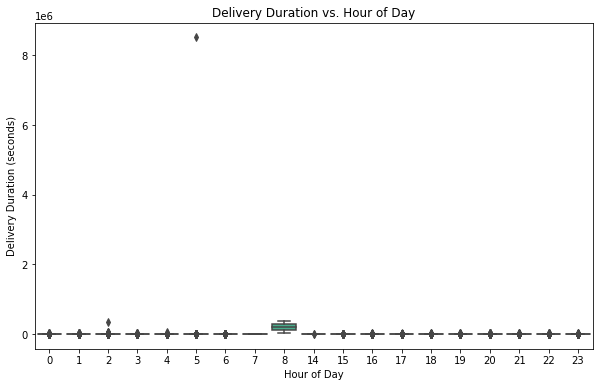

In [26]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['created_hour'], y=data['delivery_duration'])
plt.title('Delivery Duration vs. Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Delivery Duration (seconds)')
plt.show()

# Correlation Analysis

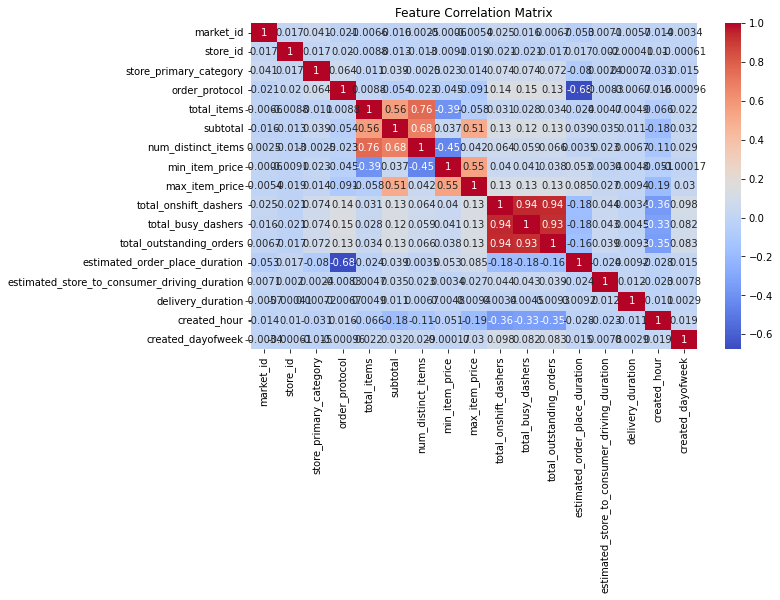

In [10]:
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

# Splitting Data

In [11]:
X = data.drop(['delivery_duration'], axis=1)
y = data['delivery_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Feature Scaling

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model Training and Selection

In [13]:
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"Performance of {model_name}:")
    print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}\n")

# Random Forest Model

In [14]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# XGBoost Model

In [15]:
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

# Neural Network Model

In [16]:
def build_neural_network(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

nn_model = build_neural_network(X_train.shape[1])
nn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)
nn_predictions = nn_model.predict(X_test).flatten()


Epoch 1/20
3949/3949 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 463329600.0000 - mae: 1585.7542 - val_loss: 5505280.0000 - val_mae: 764.9519
Epoch 2/20
3949/3949 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 3402148352.0000 - mae: 1186.4730 - val_loss: 5441896.0000 - val_mae: 740.2798
Epoch 3/20
3949/3949 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 1635790592.0000 - mae: 952.9396 - val_loss: 5412124.0000 - val_mae: 729.8918
Epoch 4/20
3949/3949 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 296760384.0000 - mae: 776.9279 - val_loss: 5395754.5000 - val_mae: 724.9070
Epoch 5/20
3949/3949 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 192334848.0000 - mae: 760.0420 - val_loss: 5393468.0000 - val_mae: 724.9717
Epoch 6/20
3949/3949 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 390222240.0000 - mae: 780.1426 - val_loss: 5392604.5000 - val_mae: 721.2910
Epoch 7/20
3949/3949 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 498580160.0000 - mae: 797.2275 - val_loss: 5390845.0000 - val_mae: 722.4492
Epoch 8/20
3949/3949 ━━

# LightGBM Model

In [17]:
lgbm_model = LGBMRegressor(random_state=42)
lgbm_model.fit(X_train, y_train)
lgbm_predictions = lgbm_model.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2066
[LightGBM] [Info] Number of data points in the train set: 157942, number of used features: 16
[LightGBM] [Info] Start training from score 2919.814483


# Evaluation of All Models

In [24]:
print("\nModel Evaluations:\n")
evaluate_model(y_test, rf_predictions, "Random Forest")
evaluate_model(y_test, xgb_predictions, "XGBoost")
evaluate_model(y_test, nn_predictions, "Neural Network")
evaluate_model(y_test, lgbm_predictions, "LightGBM")


Model Evaluations:

Performance of Random Forest:
MAE: 756.26, MSE: 58161244.33, RMSE: 7626.35, R2: -13.42

Performance of XGBoost:
MAE: 672.96, MSE: 5334308.35, RMSE: 2309.61, R2: -0.32

Performance of Neural Network:
MAE: 696.51, MSE: 3721867.29, RMSE: 1929.21, R2: 0.08

Performance of LightGBM:
MAE: 924.08, MSE: 25404310.88, RMSE: 5040.27, R2: -5.30



# Final Model Selection

In [20]:
models = {
    "Random Forest": (rf_model, rf_predictions),
    "XGBoost": (xgb_model, xgb_predictions),
    "Neural Network": (nn_model, nn_predictions),
    "LightGBM": (lgbm_model, lgbm_predictions)
}

best_model_name = max(models, key=lambda name: r2_score(y_test, models[name][1]))
best_model = models[best_model_name][0]

print(f"The best performing model is: {best_model_name}")


The best performing model is: Neural Network


# Save the Best Model and Predictions

In [21]:
if best_model_name == "Neural Network":
    nn_model.save('best_nn_model.h5')
else:
    joblib.dump(best_model, f'best_model_{best_model_name.lower()}.pkl')

# Inference using the Best Model

In [22]:
sample_data = X_test[:5]
if best_model_name == "Neural Network":
    predicted_durations = best_model.predict(sample_data).flatten()
else:
    predicted_durations = best_model.predict(sample_data)

print(f"\nSample Predictions using {best_model_name}:\n", predicted_durations)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

Sample Predictions using Neural Network:
 [2340.1497 1735.5527 2563.744  2857.385  2345.4856]


# Additional Plot: Actual vs Predicted for the Best Model

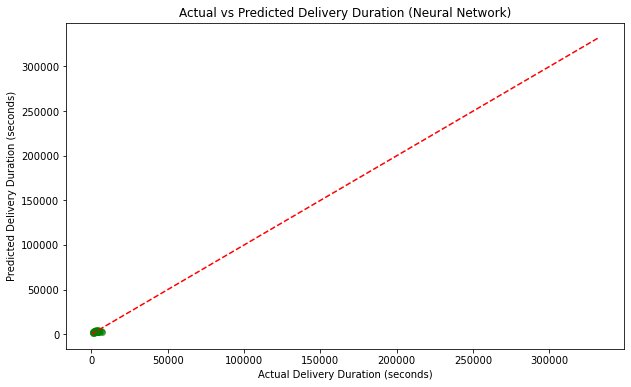

In [27]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test[:100], models[best_model_name][1][:100], alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title(f'Actual vs Predicted Delivery Duration ({best_model_name})')
plt.xlabel('Actual Delivery Duration (seconds)')
plt.ylabel('Predicted Delivery Duration (seconds)')
plt.show()